In [5]:
isFast = True

In [6]:
from __future__ import print_function
import glob
import os
import numpy as np
from PIL import Image
# Some of the flowers data is stored as .mat files
from scipy.io import loadmat
from shutil import copyfile
import sys
import tarfile
import time

# Loat the right urlretrieve based on python version
try: 
    from urllib.request import urlretrieve 
except ImportError: 
    from urllib import urlretrieve
    
import zipfile

# Useful for being able to dump images into the Notebook
import IPython.display as D

# Import CNTK and helpers
import cntk as C

In [7]:
data_root = os.path.join('.','Driving')

In [8]:
def write_to_file(file_path, img_paths, img_labels):
    with open(file_path, 'w+') as f:
        for i in range(0, len(img_paths)):
            f.write('%s\t%s\n' % (os.path.abspath(img_paths[i]), img_labels[i]))

In [9]:
def ensure_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [10]:
datasets_path = os.path.join(data_root, 'imgs')
trainset_path = os.path.join(datasets_path,'train')
testset_path = os.path.join(datasets_path,'test')
output_path = os.path.join(data_root, 'temp', 'Output')

ensure_exists(datasets_path)
ensure_exists(trainset_path)
ensure_exists(output_path)

In [11]:
training_map_file_path = os.path.join(output_path,'train_map.txt')
print("Training map file ", training_map_file_path)
test_map_file_path = os.path.join(output_path,'test_map.txt')
print("Test map file ", test_map_file_path)
eval_map_file_path = os.path.join(output_path,'eval_map.txt')
print("Eval map file ", eval_map_file_path)


from random import shuffle

def build_data_map(data_path, train_map_path, test_map_path,  eval_map_path, percentage_train, percentage_test):
    path_label = []
    
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        for file in os.listdir(folder_path):
            path_label.append([os.path.abspath(os.path.join(folder_path,file)),int(folder[1:])])
    shuffle(path_label)
    
    train_file=open(train_map_path, 'w+')
    test_file=open(test_map_path, 'w+')
    eval_file=open(eval_map_path, 'w+')
    
    i = int(len(path_label)*percentage_train/100)
    j = int(len(path_label)*(percentage_train+percentage_test)/100)
    
    for item in path_label[:i]:
            train_file.write('%s\t%s\n' % (item[0], item[1]))
    for item in path_label[i:j]:
            test_file.write('%s\t%s\n' % (item[0], item[1]))
    for item in path_label[j:]:
            eval_file.write('%s\t%s\n' % (item[0], item[1]))

build_data_map(trainset_path, training_map_file_path, test_map_file_path, eval_map_file_path, 80, 15)      

driving_data = {
        'data_folder': trainset_path,
        'training_map': os.path.abspath(training_map_file_path),
        'testing_map': os.path.abspath(test_map_file_path),
        'validation_map': os.path.abspath(eval_map_file_path)
}


Training map file  .\Driving\temp\Output\train_map.txt
Test map file  .\Driving\temp\Output\test_map.txt
Eval map file  .\Driving\temp\Output\eval_map.txt


In [12]:
def download_unless_exists(url, filename, max_retries=3):
    '''Download the file unless it already exists, with retry. Throws if all retries fail.'''
    if os.path.exists(filename):
        print('Reusing locally cached: ', filename)
    else:
        print('Starting download of {} to {}'.format(url, filename))
        retry_cnt = 0
        while True:
            try:
                urlretrieve(url, filename)
                print('Download completed.')
                return
            except:
                retry_cnt += 1
                if retry_cnt == max_retries:
                    print('Exceeded maximum retry count, aborting.')
                    raise
                print('Failed to download, retrying.')
                time.sleep(np.random.randint(1,10))

In [13]:
def download_model(model_root = os.path.join(data_root, 'PretrainedModels')):
    ensure_exists(model_root)
    resnet18_model_uri = 'https://www.cntk.ai/Models/ResNet/ResNet_18.model'
    resnet18_model_local = os.path.join(model_root, 'ResNet_18.model')
    download_unless_exists(resnet18_model_uri, resnet18_model_local)
    return resnet18_model_local

print('Downloading pre-trained model. Note: this might take a while...')
base_model_file = download_model()
print('Downloading pre-trained model complete!')

Reusing locally cached:  .\Driving\PretrainedModels\ResNet_18.model


In [14]:
# define base model location and characteristics
base_model = {
    'model_file': base_model_file,
    'feature_node_name': 'features',
    'last_hidden_node_name': 'z.x',
    # Channel Depth x Height x Width
    'image_dims': (3, 224, 224)
}

# Print out all layers in the model
print('Loading {} and printing all layers:'.format(base_model['model_file']))
node_outputs = C.logging.get_node_outputs(C.load_model(base_model['model_file']))
for l in node_outputs: print("  {0} {1}".format(l.name, l.shape))

Loading .\Driving\PretrainedModels\ResNet_18.model and printing all layers:
  ce ()
  errs ()
  top5Errs ()
  z (1000,)
  ce ()
  z (1000,)
  z.PlusArgs[0] (1000,)
  z.x (512, 1, 1)
  z.x.x.r (512, 7, 7)
  z.x.x.p (512, 7, 7)
  z.x.x.b (512, 7, 7)
  z.x.x.b.x.c (512, 7, 7)
  z.x.x.b.x (512, 7, 7)
  z.x.x.b.x._ (512, 7, 7)
  z.x.x.b.x._.x.c (512, 7, 7)
  z.x.x.x.r (512, 7, 7)
  z.x.x.x.p (512, 7, 7)
  z.x.x.x.b (512, 7, 7)
  z.x.x.x.b.x.c (512, 7, 7)
  z.x.x.x.b.x (512, 7, 7)
  z.x.x.x.b.x._ (512, 7, 7)
  z.x.x.x.b.x._.x.c (512, 7, 7)
  _z.x.x.x.r (512, 7, 7)
  _z.x.x.x.p (512, 7, 7)
  _z.x.x.x.b (512, 7, 7)
  _z.x.x.x.b.x.c (512, 7, 7)
  _z.x.x.x.b.x (512, 7, 7)
  _z.x.x.x.b.x._ (512, 7, 7)
  _z.x.x.x.b.x._.x.c (512, 7, 7)
  z.x.x.x.x.r (256, 14, 14)
  z.x.x.x.x.p (256, 14, 14)
  z.x.x.x.x.b (256, 14, 14)
  z.x.x.x.x.b.x.c (256, 14, 14)
  z.x.x.x.x.b.x (256, 14, 14)
  z.x.x.x.x.b.x._ (256, 14, 14)
  z.x.x.x.x.b.x._.x.c (256, 14, 14)
  z.x.x.x.x.x.r (256, 14, 14)
  z.x.x.x.x.x.p (256, 1

In [15]:
def plot_images(images, subplot_shape):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(*subplot_shape)
    for image, ax in zip(images, axes.flatten()):
        ax.imshow(image.reshape(28, 28), vmin = 0, vmax = 1.0, cmap = 'gray')
        ax.axis('off')
    plt.show()

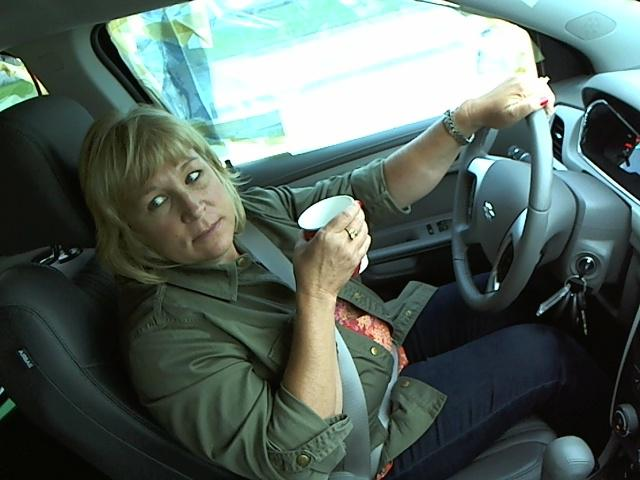

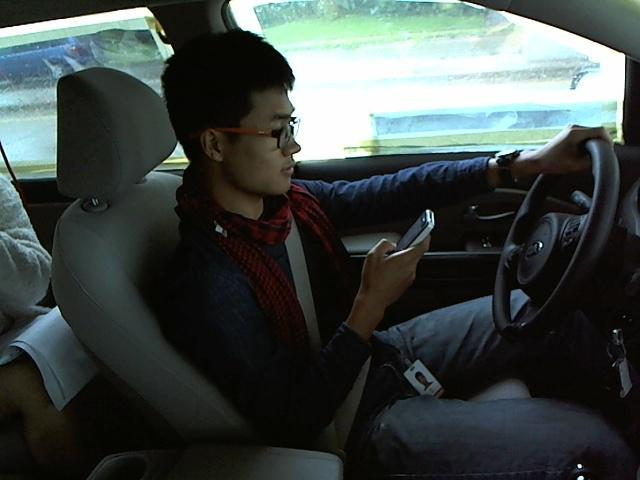

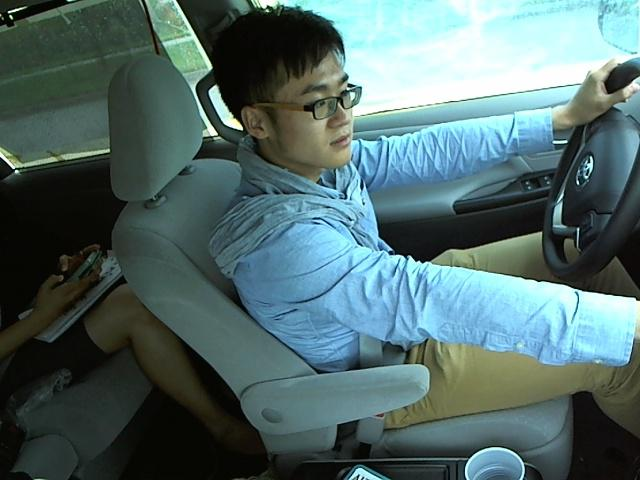

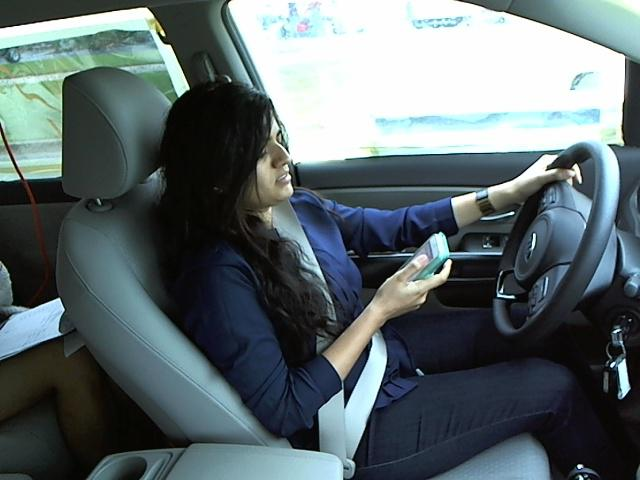

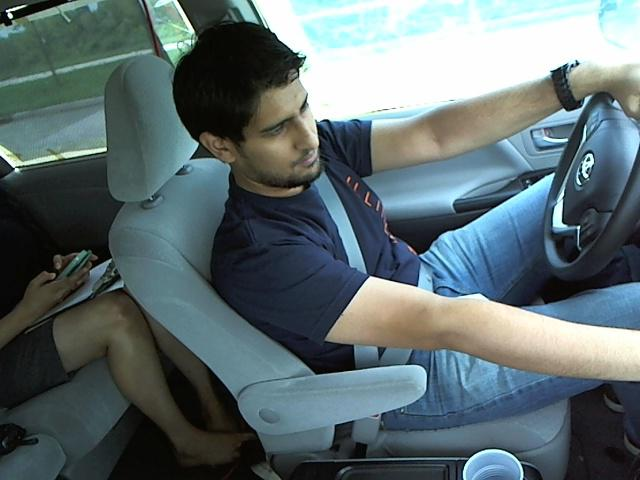

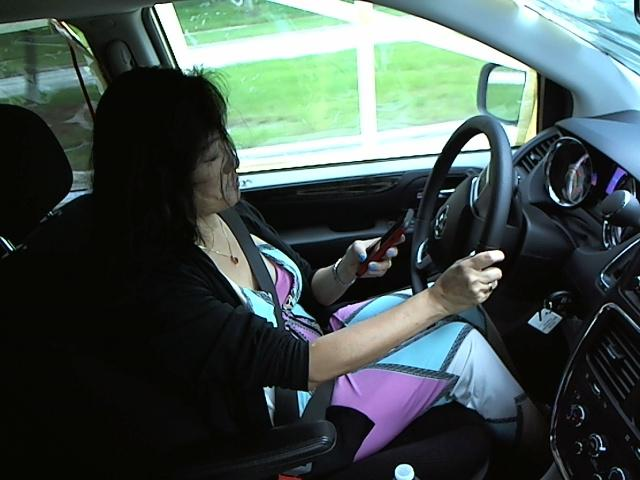

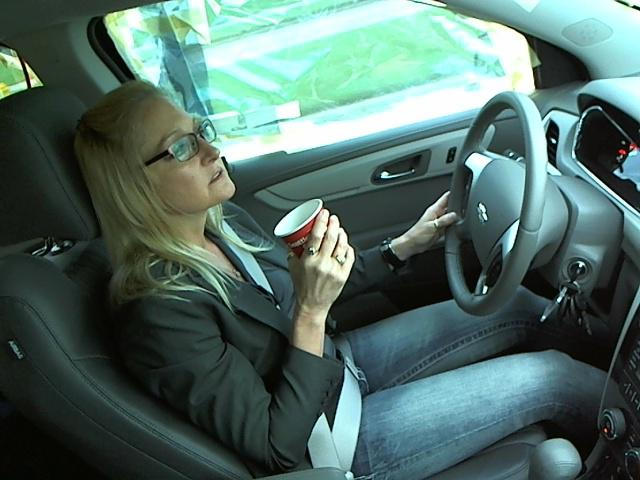

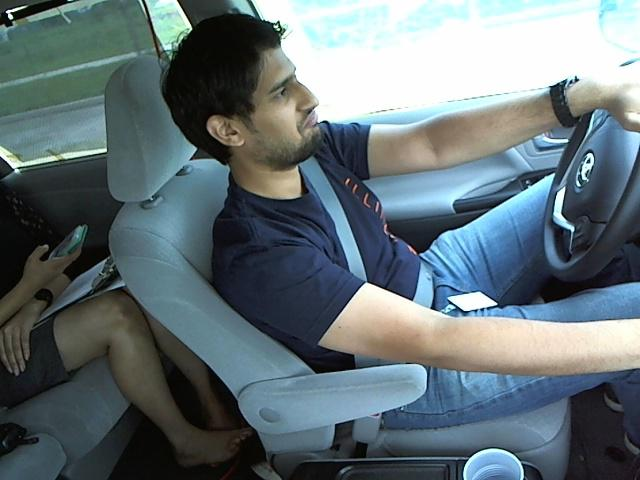

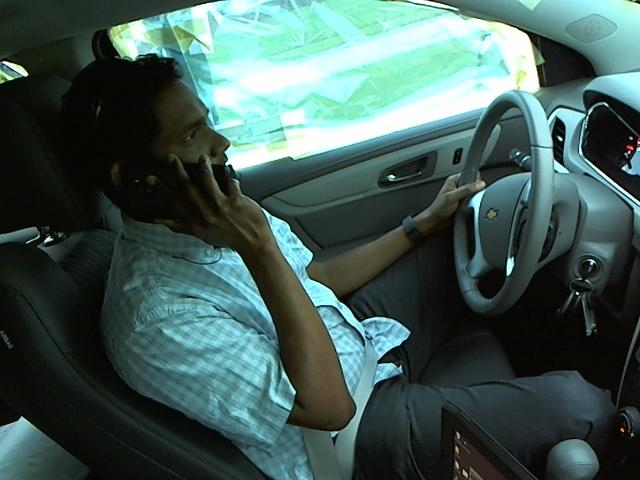

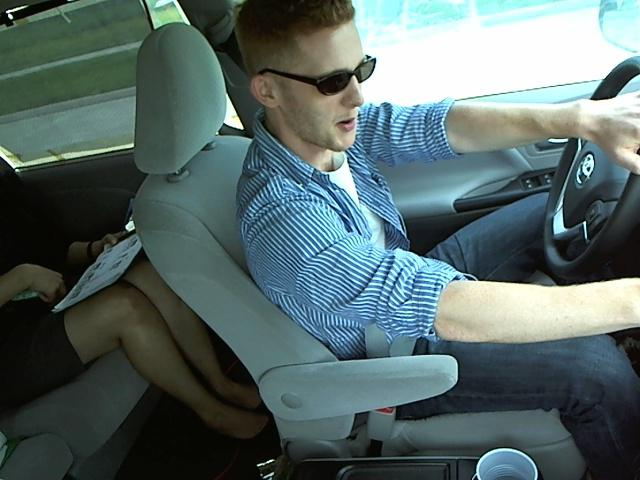

In [16]:
f=open(eval_map_file_path,'r')

for i in range(10):
    line = f.readline()
    img = line.split('\t')[0]
    D.display(D.Image(img), width=100, height=100)

In [17]:
import cntk.io.transforms as xforms
ensure_exists(output_path)
np.random.seed(123)

# Creates a minibatch source for training or testing
def create_mb_source(map_file, image_dims, num_classes, randomize=True):
    transforms = [xforms.scale(width=image_dims[2], height=image_dims[1], channels=image_dims[0], interpolations='linear')]
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
            features=C.io.StreamDef(field='image', transforms=transforms),
            labels=C.io.StreamDef(field='label', shape=num_classes))),
            randomize=randomize)

# Creates the network model for transfer learning
def create_model(model_details, num_classes, input_features, new_prediction_node_name='prediction', freeze=False):
    # Load the pretrained classification net and find nodes
    base_model = C.load_model(model_details['model_file'])
    feature_node = C.logging.find_by_name(base_model, model_details['feature_node_name'])
    last_node = C.logging.find_by_name(base_model, model_details['last_hidden_node_name'])

    # Clone the desired layers with fixed weights
    cloned_layers = C.combine([last_node.owner]).clone(
        C.CloneMethod.freeze if freeze else C.CloneMethod.clone,
        {feature_node: C.placeholder(name='features')})

    # Add new dense layer for class prediction
    feat_norm = input_features - C.Constant(114)
    cloned_out = cloned_layers(feat_norm)
    z = C.layers.Dense(num_classes, activation=None, name=new_prediction_node_name) (cloned_out)

    return z

In [18]:
# Trains a transfer learning model
def train_model(model_details, num_classes, train_map_file,
                learning_params, max_images=-1):
    num_epochs = learning_params['max_epochs']
    epoch_size = sum(1 for line in open(train_map_file))
    if max_images > 0:
        epoch_size = min(epoch_size, max_images)
    minibatch_size = learning_params['mb_size']
    
    # Create the minibatch source and input variables
    minibatch_source = create_mb_source(train_map_file, model_details['image_dims'], num_classes)
    image_input = C.input_variable(model_details['image_dims'])
    label_input = C.input_variable(num_classes)

    # Define mapping from reader streams to network inputs
    input_map = {
        image_input: minibatch_source['features'],
        label_input: minibatch_source['labels']
    }

    # Instantiate the transfer learning model and loss function
    tl_model = create_model(model_details, num_classes, image_input, freeze=learning_params['freeze_weights'])
    ce = C.cross_entropy_with_softmax(tl_model, label_input)
    pe = C.classification_error(tl_model, label_input)

    # Instantiate the trainer object
    lr_schedule = C.learning_rate_schedule(learning_params['lr_per_mb'], unit=C.UnitType.minibatch)
    mm_schedule = C.momentum_schedule(learning_params['momentum_per_mb'])
    learner = C.momentum_sgd(tl_model.parameters, lr_schedule, mm_schedule, 
                           l2_regularization_weight=learning_params['l2_reg_weight'])
    trainer = C.Trainer(tl_model, (ce, pe), learner)

    # Get minibatches of images and perform model training
    print("Training transfer learning model for {0} epochs (epoch_size = {1}).".format(num_epochs, epoch_size))
    C.logging.log_number_of_parameters(tl_model)
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=num_epochs)
    for epoch in range(num_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = minibatch_source.next_minibatch(min(minibatch_size, epoch_size - sample_count), input_map=input_map)
            trainer.train_minibatch(data)                                    # update model with it
            sample_count += trainer.previous_minibatch_sample_count          # count samples processed so far
            progress_printer.update_with_trainer(trainer, with_metric=True)  # log progress
            if sample_count % (100 * minibatch_size) == 0:
                print ("Processed {0} samples".format(sample_count))

        progress_printer.epoch_summary(with_metric=True)

    return tl_model

In [19]:
force_retraining = True

max_training_epochs = 5 if isFast else 20

learning_params = {
    'max_epochs': max_training_epochs,
    'mb_size': 50,
    'lr_per_mb': [0.2]*10 + [0.1],
    'momentum_per_mb': 0.9,
    'l2_reg_weight': 0.0005,
    'freeze_weights': True
}

driving_model = {
    'model_file': os.path.join(output_path, 'DrivingTransferLearning.model'),
    'results_file': os.path.join(output_path, 'DrivingPredictions.txt'),
    'num_classes': 10
}

# Train only if no model exists yet or if force_retraining is set to True
if os.path.exists(driving_model['model_file']) and not force_retraining:
    print("Loading existing model from %s" % driving_model['model_file'])
    trained_model = C.load_model(driving_model['model_file'])
else:
    trained_model = train_model(base_model,
                                driving_model['num_classes'], driving_data['training_map'],
                                learning_params)
    trained_model.save(driving_model['model_file'])
    print("Stored trained model at %s" % driving_model['model_file'])

Training transfer learning model for 5 epochs (epoch_size = 17939).
Training 5130 parameters in 2 parameter tensors.
Processed 5000 samples
Processed 10000 samples
Processed 15000 samples
Finished Epoch[1 of 5]: [Training] loss = 0.716967 * 17939, metric = 22.96% * 17939 96.062s (186.7 samples/s);
Processed 5000 samples
Processed 10000 samples
Processed 15000 samples
Finished Epoch[2 of 5]: [Training] loss = 0.297063 * 17939, metric = 9.40% * 17939 90.935s (197.3 samples/s);
Processed 5000 samples
Processed 10000 samples
Processed 15000 samples
Finished Epoch[3 of 5]: [Training] loss = 0.244524 * 17939, metric = 7.58% * 17939 90.236s (198.8 samples/s);
Processed 5000 samples
Processed 10000 samples
Processed 15000 samples
Finished Epoch[4 of 5]: [Training] loss = 0.210901 * 17939, metric = 6.43% * 17939 89.641s (200.1 samples/s);
Processed 5000 samples
Processed 10000 samples
Processed 15000 samples
Finished Epoch[5 of 5]: [Training] loss = 0.192537 * 17939, metric = 6.10% * 17939 90.9

In [20]:
# Evaluates a single image using the re-trained model
def eval_single_image(loaded_model, image_path, image_dims):
    # load and format image (resize, RGB -> BGR, CHW -> HWC)
    try:
        img = Image.open(image_path)
        
        if image_path.endswith("png"):
            temp = Image.new("RGB", img.size, (255, 255, 255))
            temp.paste(img, img)
            img = temp
        resized = img.resize((image_dims[2], image_dims[1]), Image.ANTIALIAS)
        bgr_image = np.asarray(resized, dtype=np.float32)[..., [2, 1, 0]]
        hwc_format = np.ascontiguousarray(np.rollaxis(bgr_image, 2))

        # compute model output
        arguments = {loaded_model.arguments[0]: [hwc_format]}
        output = loaded_model.eval(arguments)

        # return softmax probabilities
        sm = C.softmax(output[0])
        return sm.eval()
    except FileNotFoundError:
        print("Could not open (skipping file): ", image_path)
        return ['None']

In [21]:
# Evaluates an image set using the provided model
def eval_test_images(loaded_model, output_file, test_map_file, image_dims, max_images=-1, column_offset=0):
    num_images = sum(1 for line in open(test_map_file))
    if max_images > 0:
        num_images = min(num_images, max_images)
    if isFast:
        num_images = min(num_images, 300) #We will run through fewer images for test run
        
    print("Evaluating model output node '{0}' for {1} images.".format('prediction', num_images))

    pred_count = 0
    correct_count = 0
    np.seterr(over='raise')
    with open(output_file, 'wb') as results_file:
        with open(test_map_file, "r") as input_file:
            for line in input_file:
                tokens = line.rstrip().split('\t')
                img_file = tokens[0 + column_offset]
                probs = eval_single_image(loaded_model, img_file, image_dims)
                
                if probs[0]=='None':
                    print("Eval not possible: ", img_file)
                    continue

                pred_count += 1
                true_label = int(tokens[1 + column_offset])
                predicted_label = np.argmax(probs)
                if predicted_label == true_label:
                    correct_count += 1

                #np.savetxt(results_file, probs[np.newaxis], fmt="%.3f")
                if pred_count % 100 == 0:
                    print("Processed {0} samples ({1:.2%} correct)".format(pred_count, 
                                                                           (float(correct_count) / pred_count)))
                if pred_count >= num_images:
                    break
    print ("{0} of {1} prediction were correct".format(correct_count, pred_count))
    return correct_count, pred_count, (float(correct_count) / pred_count)

In [22]:
# Evaluate the test set
predict_correct, predict_total, predict_accuracy = \
   eval_test_images(trained_model, driving_model['results_file'], driving_data['testing_map'], base_model['image_dims'])
print("Done. Wrote output to %s" % driving_model['results_file'])

Evaluating model output node 'prediction' for 300 images.


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Processed 100 samples (88.00% correct)
Processed 200 samples (88.50% correct)
Processed 300 samples (90.33% correct)
271 of 300 prediction were correct
Done. Wrote output to .\Driving\temp\Output\DrivingPredictions.txt


In [ ]:
import csv
submission_example = os.path.join(data_root,'submission.csv')
with open(submission_example, newline='') as f:
    reader = csv.reader(f)
    header = reader.__next__()
    
print(header)
submission = os.path.join(data_root,'submission_new.csv')

i=0

with open(submission, 'w', newline='') as f:
    writer = csv.writer(f,delimiter=',')
    writer.writerow(header)
    
    test_dir=os.path.join(datasets_path,'test')
    for img in os.listdir(test_dir):
        prediction = eval_single_image(trained_model, os.path.join(test_dir, img),base_model['image_dims'])[0]
        writer.writerow(['{0:.1f}'.format(x) for x in prediction])
        if i % 1000 == 0:
            print (i)
            print (prediction)
        i=i+1
        

['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
0
[  2.77779123e-04   3.92099167e-07   2.91963175e-07   9.88315344e-01
   6.25460828e-03   4.90335096e-03   1.19104507e-05   4.90885213e-06
   1.46936829e-04   8.43725065e-05]
1000
[  1.97815150e-03   1.10199361e-03   4.69308585e-01   9.13051990e-05
   7.99524860e-05   3.43679392e-04   1.64087322e-02   2.72839844e-01
   1.21616848e-01   1.16230853e-01]
2000
[  1.39794573e-02   4.72078085e-01   5.91998742e-06   1.44433426e-02
   1.79661193e-03   3.66869546e-03   2.87329871e-02   3.31441820e-01
   1.88229010e-02   1.15030088e-01]
3000
[  5.31838486e-05   1.51257031e-03   4.70617397e-06   2.04236858e-06
   2.98555551e-06   3.87368292e-01   4.30407090e-06   1.23887017e-04
   1.09697583e-04   6.10818207e-01]
4000
[  1.81692289e-04   9.16326651e-04   2.98224925e-03   1.76644371e-05
   2.39535235e-04   4.33069479e-04   2.61022449e-02   7.59114073e-06
   3.44937854e-02   9.34625745e-01]
5000
[  2.01081228e-03   6.29721701e-01 